In this notebook I will visualize some of the paintings created, first when allowing for all copies (under chromopaintings), and the only allowing to copy from other pops.

In [75]:
%run ../scripts/notebook_settings.py
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
recomb_map_path = "/faststorage/project/baboondiversity/data/haploidified_chrX_males/uniform_rec_10cM.recombfile"
idfile_path = "/faststorage/project/baboondiversity/data/haploidified_chrX_males/idfile.ids"

In [18]:
#Functions to generate the stacked area plot df

#Should be easily extendable to multiple paintings by repeating the loop
def count_paint_windows(pop_dict, spot_df, window):
    pop_dict["window"] = list(range(end_pos//window+1))
    for window_number in range(end_pos//window+1):
        #Selecting the rows which are inside
        window_start = window*window_number
        window_end = window*(window_number+1)-1
        sub_df = spot_df.loc[(spot_df.end_pos >= window_start)
                    & (spot_df.pos < window_end)]
        total_paint = 0
        for i, row in sub_df.iterrows():
            #When the painting covers the whole window
            if len(sub_df) == 1:
                pop_dict[row["pop"]][window_number] += window
                total_paint += window
            #When the painting started before the window
            elif row.pos < window_start:
                pop_dict[row["pop"]][window_number] += row.end_pos-window_start
                total_paint += row.end_pos-window_start
            #When the painting ends after the window
            elif row.end_pos > window_end:
                pop_dict[row["pop"]][window_number] += window_end-row.pos
                total_paint += window_end-row.pos
            #When the painting is fully in the window
            else:
                pop_dict[row["pop"]][window_number] += row.paint_length
                total_paint += row.paint_length
    return pop_dict

def generate_spot_df(single_p_df, map_dict):
    single_p_df["pop"] = single_p_df["paint"].map(map_dict)
    shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
    #df based on this subset
    spot_df = single_p_df.loc[shift_spots].copy()
    #Finding the start of the next painting, by removing the first pos and adding the last snp.
    #And then calculating the difference.
    spot_df["paint_length"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values)
    spot_df["end_pos"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1)
    return spot_df

In [5]:
#Files to load
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index+1
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index+1
recomb_map = pd.read_csv(recomb_map_path, sep=" ")
pos_list = recomb_map["start.pos"]

Single individual test

In [106]:
#Variable definition, in the case in which we do not allow in_pop copying.
window = 1000000
def create_paint_df(pop_inv, window):
    no_inpop_donor = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/cp_gt_scaled_rec/{}scaled_rec/chromopaintings/sample{}.samples.out"

    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    pop_dict = {}
    for population in idfile.loc[idfile.inclusion==1]["pop"].unique():
        pop_dict[population] = [0]*(end_pos//window+1)
    
    map_dict = {}
    for i, row in idfile.iterrows():
        map_dict[row.ID_index] = row["pop"]

    df_l = []
    for i in range(len(idfile.loc[idfile["pop"] == pop_inv])):
        f = open(no_inpop_donor.format(pop_inv, i), "r")
        ad_lines = f.readlines()
        print(i)
        for p_num in range(10):
            paint_line = ad_lines[2+p_num].strip().split(" ")[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            sub_dict = count_paint_windows(pop_dict, spot_df, window)
            sub_df = pd.DataFrame(sub_dict)
            sub_df["paint".format(p_num)]=p_num
            sub_df["individual"] = i
            df_l.append(sub_df)
    all_df = pd.concat(df_l)
    all_df = all_df.set_index("window")
    return all_df

In [ ]:
all_df = create_paint_df("Anubis_Tarangire_Ngorongoro_Manyara", window)

In [95]:
def stairs(df, start='start', end='end', pos='pos', endtrim=0, window=window):
    df["start"] = df.index.values*window
    df["end"] = df.index.values*window+window
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

In [72]:
stair_df = stairs(all_df, endtrim=1)
stair_df = stair_df.drop(columns=["paint", "individual", "start", "end"])
stair_df = pd.melt(stair_df, id_vars="pos")

In [79]:
stair_df.variable.unique()

array(['Cynocephalus_Ruaha_Udzungwa_Selous',
       'Cynocephalus_Western_Tanzania', 'Cynocephalus_Mikumi',
       'Anubis_Gombe_Serengeti', 'Anubis_Tarangire_Ngorongoro_Manyara',
       'Anubis_Ethiopia', 'Kindae_Zambia', 'Hamadryas_Ethiopia'],
      dtype=object)

[Text(0.5, 1.0, 'Anubis from Tarangire, Ngorongoro, Manyara')]

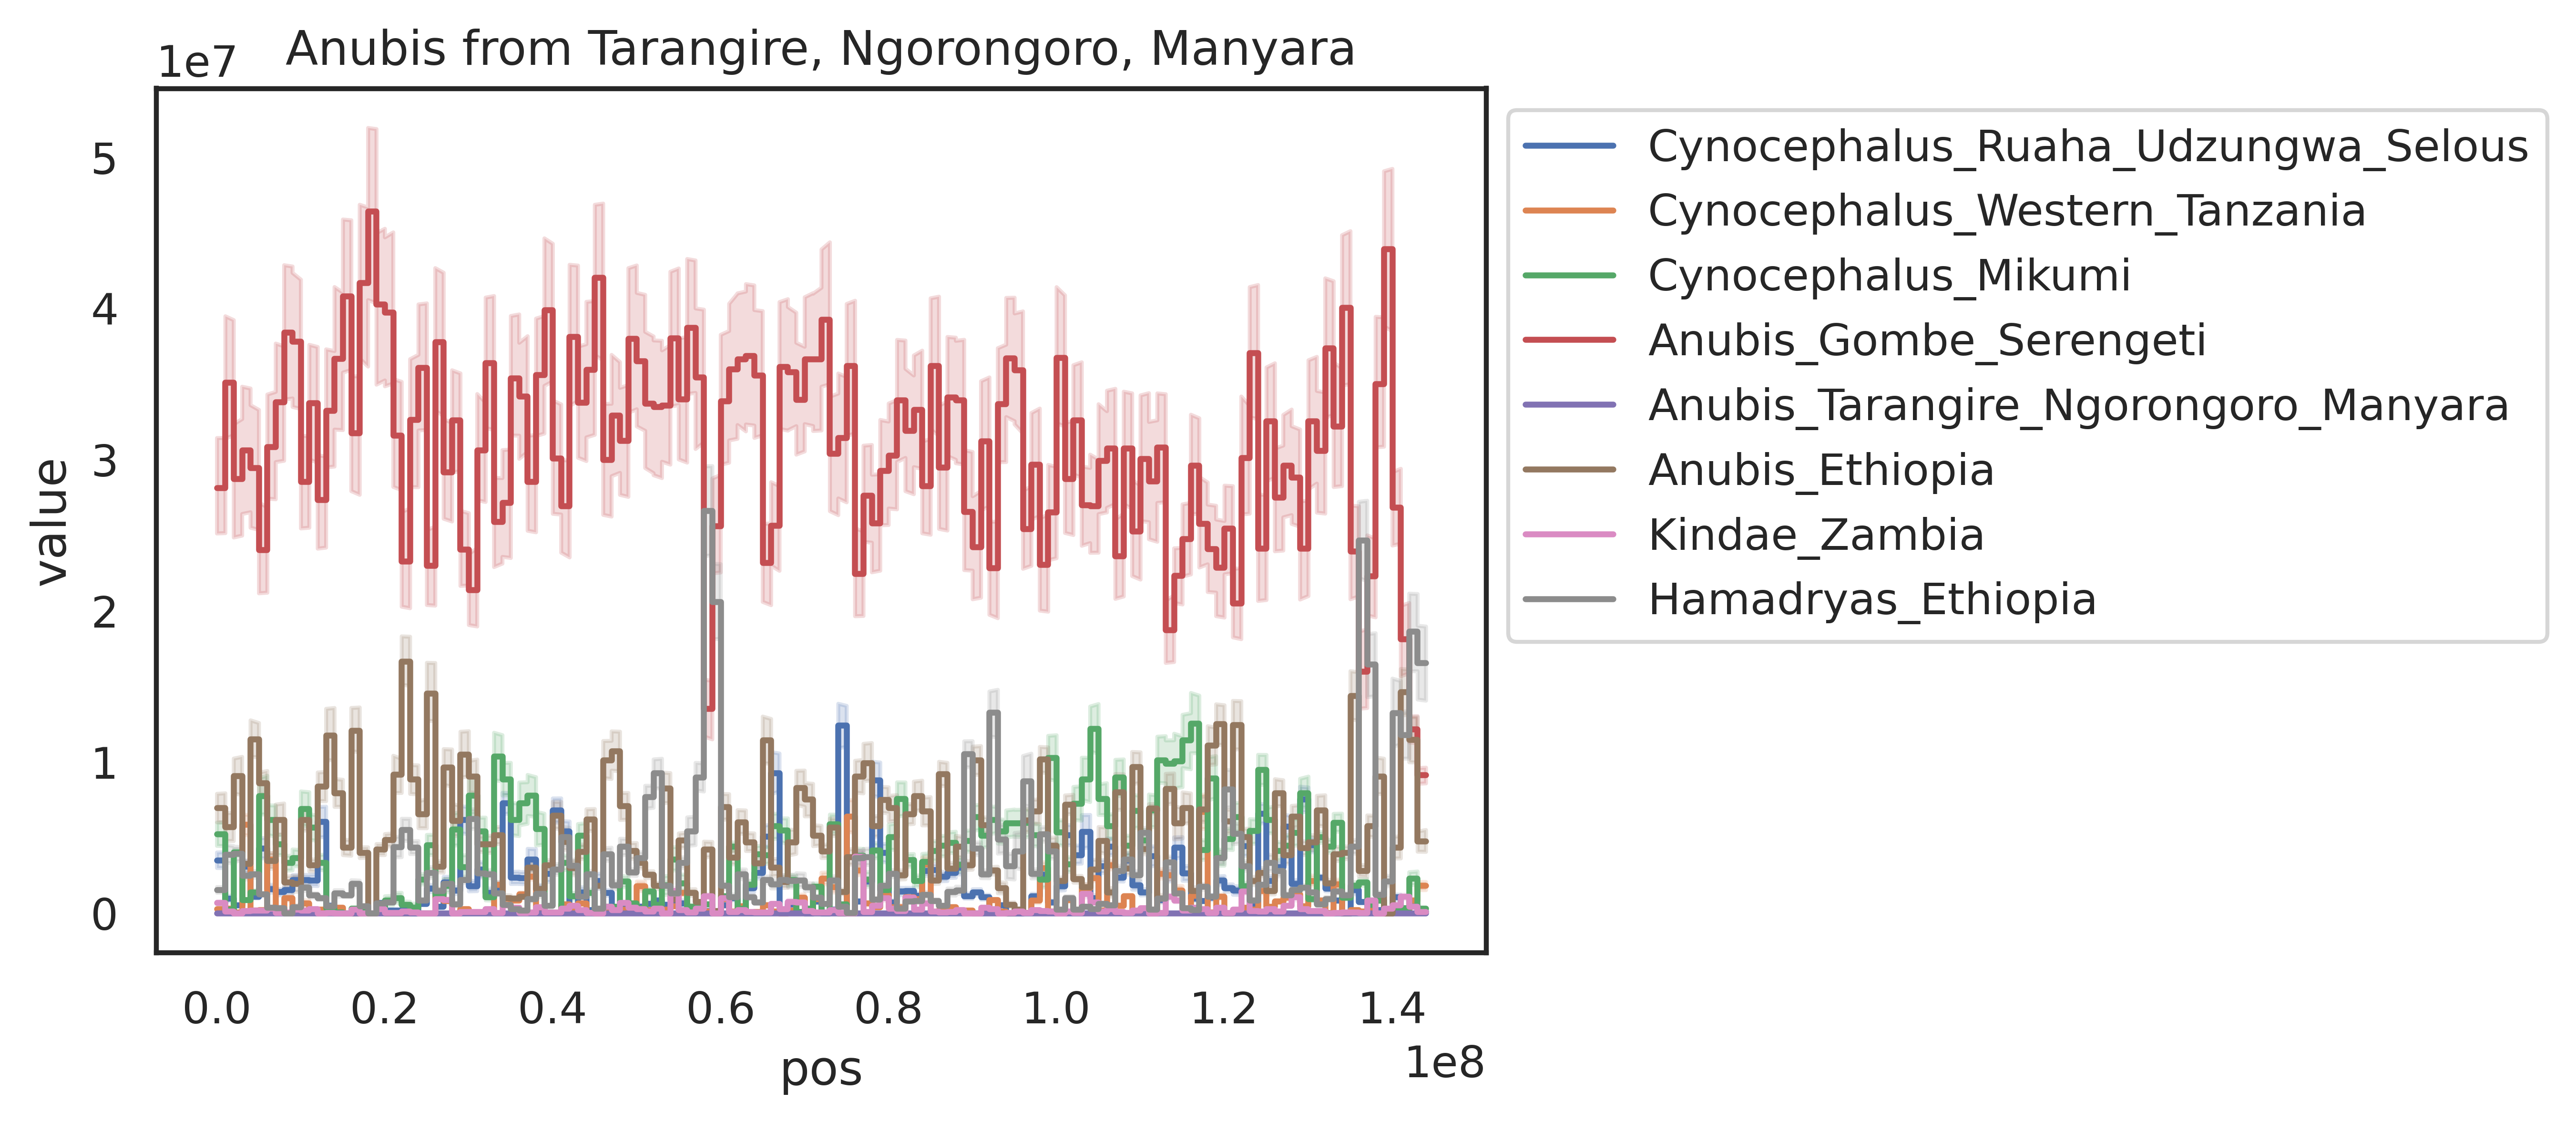

In [82]:
g = sns.lineplot(data=stair_df, x="pos", y="value", hue="variable")
g.legend(bbox_to_anchor=(1,1))
g.set(title="Anubis from Tarangire, Ngorongoro, Manyara")

In [107]:
all_df = create_paint_df("Cynocephalus_Western_Tanzania", window)

0
1
2
3
4
5
6


In [108]:
stair_df = stairs(all_df, endtrim=1)
stair_df = stair_df.drop(columns=["paint", "individual", "start", "end"])
stair_df = pd.melt(stair_df, id_vars="pos")

[Text(0.5, 1.0, 'Cynocephalus from Western Tanzania')]

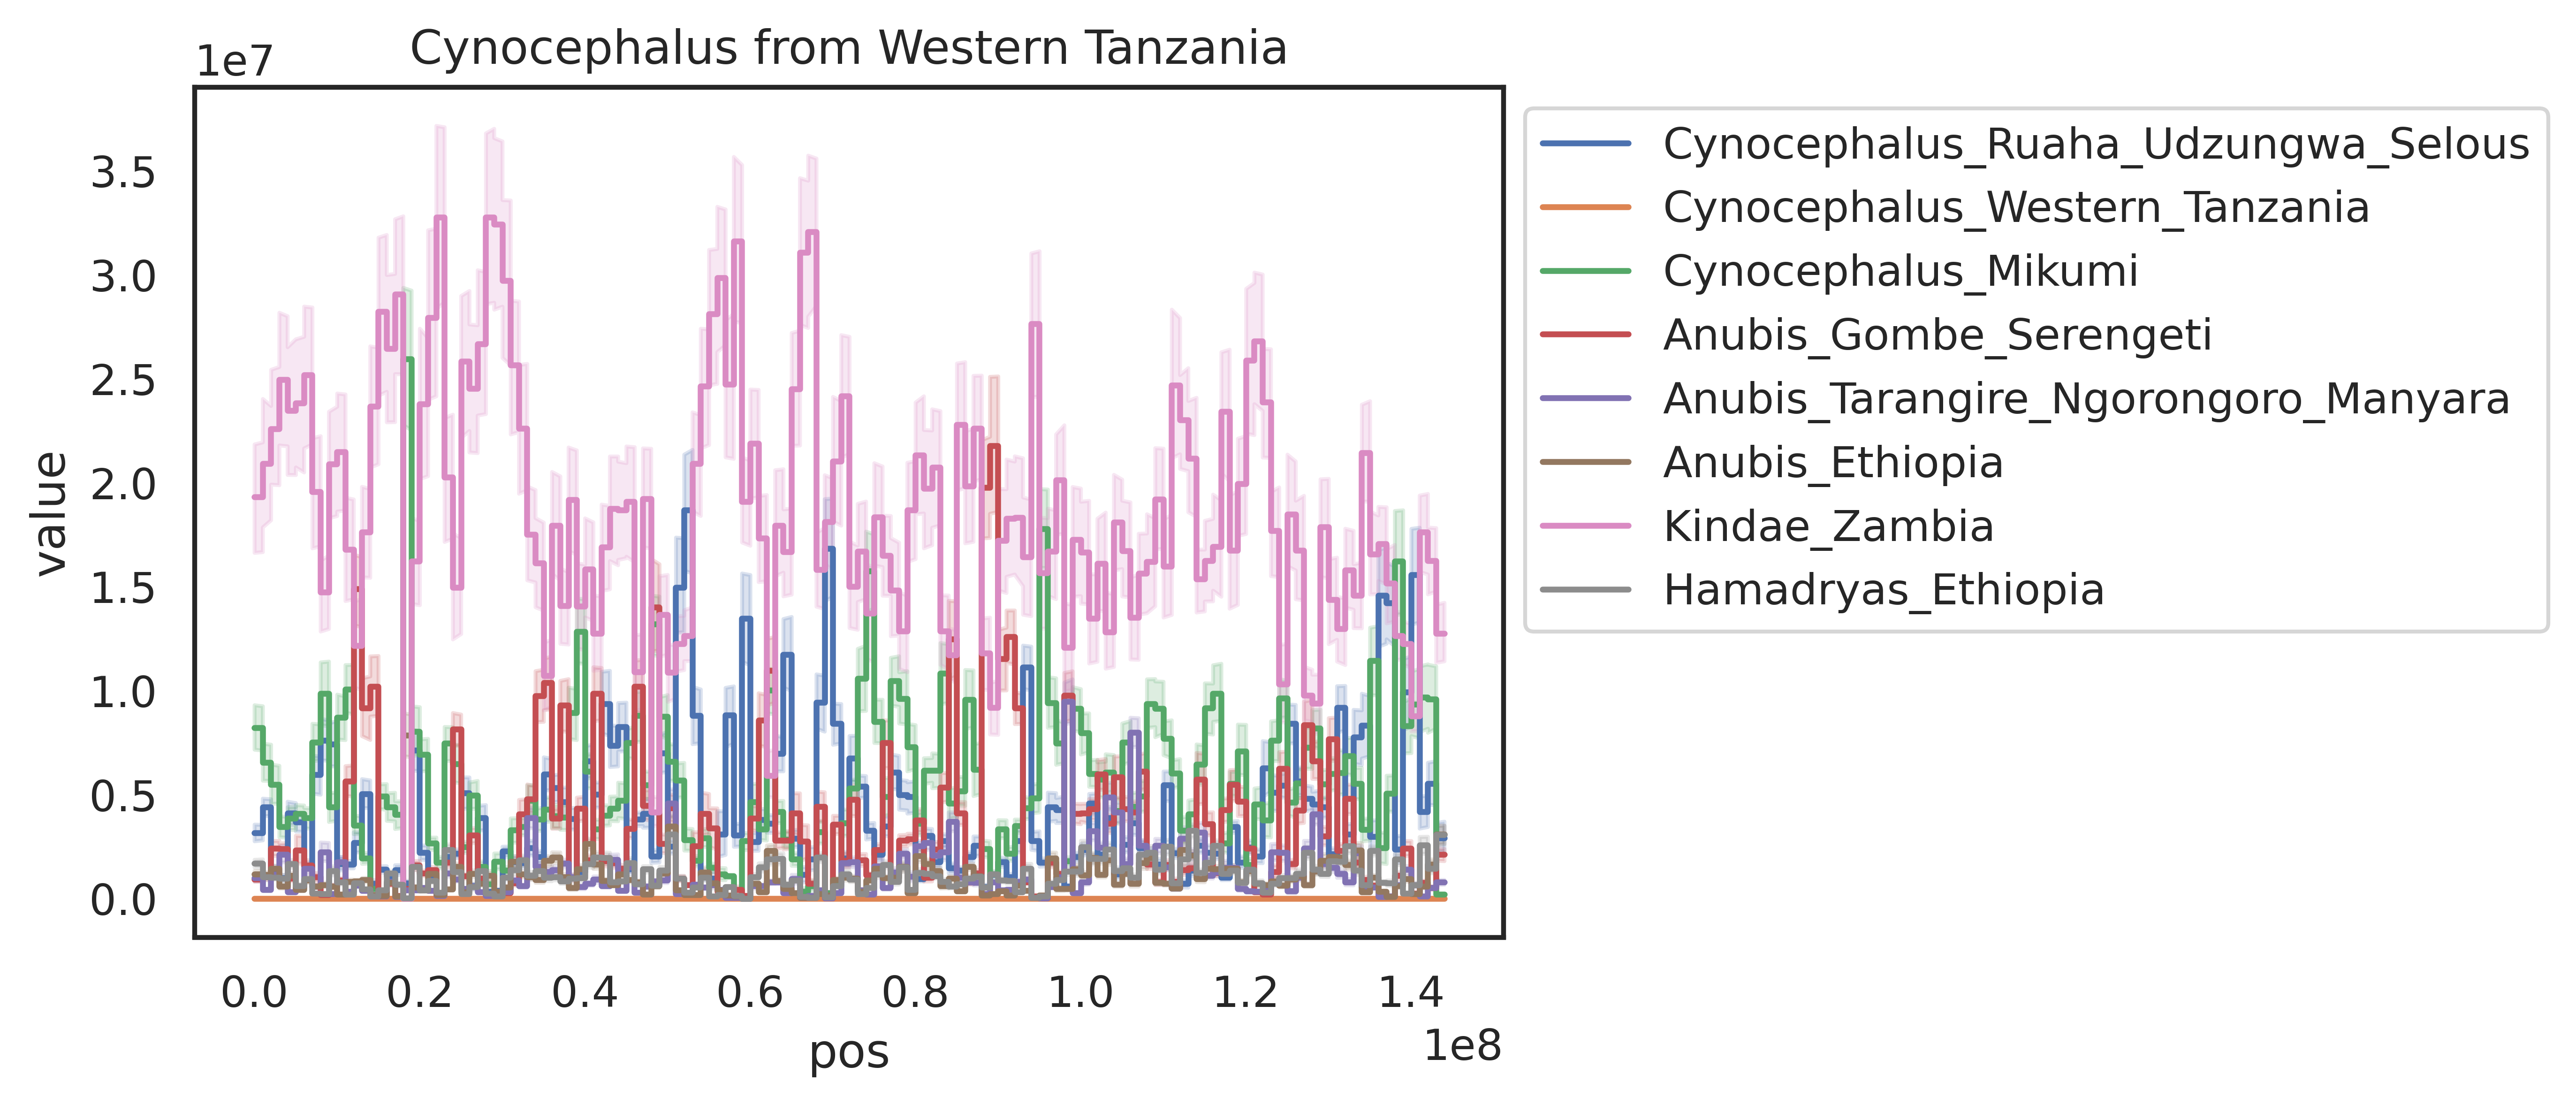

In [109]:
g = sns.lineplot(data=stair_df, x="pos", y="value", hue="variable")
g.legend(bbox_to_anchor=(1,1))
g.set(title="Cynocephalus from Western Tanzania")

In [ ]:
#Variable definition, in the case in which we do not allow in_pop copying.
window = 1000000
pop_inv = "Anubis_Tarangire_Ngorongoro_Manyara"
no_inpop_donor = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/cp_gt_scaled_rec/{}scaled_rec/chromopaintings/sample{}.samples.out"

#various supplemental dataframes/lists
end_pos = pos_list.values[-1]
pop_dict = {}
for population in idfile.loc[idfile.inclusion==1]["pop"].unique():
    pop_dict[population] = [0]*(end_pos//window+1)
    
map_dict = {}
for i, row in idfile.iterrows():
    map_dict[row.ID_index] = row["pop"]

for i in range(len(idfile.loc[idfile["pop"] == pop_inv])):
    f = open(no_inpop_donor.format(pop_inv, i), "r")
    ad_lines = f.readlines()
    print(i)
    for p_num in range(10):
        paint_line = ad_lines[2+p_num].strip().split(" ")[1:]
        single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
        single_p_df = single_p_df.astype(int)
        spot_df = generate_spot_df(single_p_df, map_dict)
        pop_dict = count_paint_windows(pop_dict, spot_df, window)
paintings_df = pd.DataFrame(data=pop_dict)

In [17]:
sns.lineplot(all_df)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


ValueError: If using all scalar values, you must pass an index

In [ ]:
paintings_df = pd.DataFrame(data=pop_dict)
paintings_df.sum().sum()/(window*len(paintings_df))

In [ ]:
g = paintings_df.plot.area().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [ ]:
#When iterating through the data that allows all non-self copying
all_donor = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/cp_gt_scaled_rec/chromopaintings/copy{}.samples.out"
for i, row in (idfile.loc[idfile["pop"] == pop_inv]).iterrows():
    f = open(all_donor.format(row.ID_index-1), "r")
    ad_lines = f.readlines()
    print(i)
    for p_num in range(10):
        paint_line = ad_lines[2+p_num].strip().split(" ")[1:]
        single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
        single_p_df = single_p_df.astype(int)
        spot_df = generate_spot_df(single_p_df, map_dict)
        pop_dict = count_paint_windows(pop_dict, spot_df, window)
paintings_df_all_donor = pd.DataFrame(data=pop_dict)

In [ ]:
g = paintings_df_all_donor.plot.area().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [ ]:
x_index = range(end_pos//window+1)
l_l = []
label_l = []
for key in pop_dict:
    l_l.append(pop_dict[key])
    label_l.append(key)
l_l = np.array(l_l)

In [ ]:
plt.stackplot(x_index, l_l, labels=label_l)
plt.legend(bbox_to_anchor = [1.85, 1.03])

Old code to test and create the implementation shown above

In [ ]:
f = open(no_inpop_donor, "r")
ad_lines = f.readlines()
ad_lines[1]

In [ ]:
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile.loc[idfile["pop"] == "Anubis_Tarangire_Ngorongoro_Manyara"]

In [ ]:
idfile["pop"].unique()

In [ ]:
idfile["ID_index"] = idfile.index+1

In [ ]:
map_dict = {}
for i, row in idfile.iterrows():
    map_dict[row.ID_index] = row["pop"]

In [ ]:
recomb_map = pd.read_csv(recomb_map_path, sep=" ")
pos_list = recomb_map["start.pos"]

In [ ]:
paint_line = ad_lines[2].strip().split(" ")[1:]

Creating a dataframe containing a single painting sample.
Note: Positions correspond to index in idfile+1

In [ ]:
single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
single_p_df = single_p_df.astype(int)

In [ ]:
single_p_df["paint"].values.max(), len(idfile)
#P. Papio is not included, and are the last

In [ ]:
single_p_df["pop"] = single_p_df["paint"].map(map_dict)

Calculating position/lengths of runs by finding the rows in which it changes.

In [ ]:
#Boolean which is true when the value changes
shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
#df based on this subset
spot_df = single_p_df.loc[shift_spots]
#Finding the start of the next painting, by removing the first pos and adding the last snp.
#And then calculating the difference.
spot_df["paint_length"] = np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values
spot_df["end_pos"] = np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1

In [ ]:
g = sns.FacetGrid(data=spot_df, col="pop")
g.map(sns.histplot, "paint_length")

Testing a stackplot

In [ ]:
x=range(1,4)
y = [[0.4, 0.9, 0.2], [0.6, 0.1, 0.8]]
plt.stackplot(x,y, labels=["Cyno", "Anubis"])
plt.legend(loc='upper left')